# MS Topo Layer API Query

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os, sys
sys.path.append('../scripts/')
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from osdatahub import NGD
from osdatahub import Extent
from dotenv import load_dotenv

#### Setting up the API
Location data is fetched from OS Data Hub APIs. This analysis uses Premium data from the OS Features API, so you will need a Premium account.

In [29]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [30]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building v1 (bld-fts-building-1)
 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-conn

### Select site area

In [31]:
# load the NCA for the PDNP https://naturalengland-defra.opendata.arcgis.com/datasets/national-character-areas-england
nca = "../content/nca_areas/National_Character_Areas___Natural_England.shp"
nca = gpd.read_file(nca)

<AxesSubplot:>

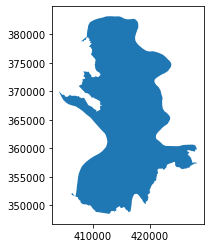

In [32]:
# select the white peak
wp = nca[nca.NCA_Name=="White Peak"]
# load pdnp boundary https://naturalengland-defra.opendata.arcgis.com/datasets/national-parks-england/explore
np = "../content/pdnp_boundary/National_Parks_(England)___Natural_England.shp"
np = gpd.read_file(np)
pdnp = np[np.NAME=="PEAK DISTRICT"]
# Cut WP to PDNP boundary
pdnp_wp = gpd.clip(wp,pdnp)
pdnp_wp.plot(figsize=(4,4))

Small area at bottom of the wp nca that doen's quite extend the pdnp boundary. Maybe needs adding back in will give it some thought. Won't matter with intersection of 1km Grid but probably would with a patch intersection. 

#### Grid Selctor

<AxesSubplot:>

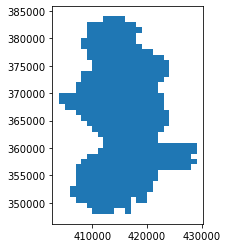

In [33]:
# load pdnp boundary 
lcg = "../content/landscape_character_grid/Landscape_Character_Grid.shp"
lcg = gpd.read_file(lcg)
# Select grid by intersection
lcg_wp = gpd.sjoin(lcg, pdnp_wp)
lcg_wp.plot(figsize=(4,4))

In [34]:
# save as a new file 
out_file_path = r"../content/landscape_character_grid/selection_white_peak.shp"
lcg_wp.to_file(out_file_path)
# Get a list of tiles for the project
tile_num = lcg_wp['PLAN_NO']
print(len(tile_num))

C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\772195361.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lcg_wp.to_file(out_file_path)


500


#### Create Sample area

In [35]:
# A3_80 = Walls 5 highest area of lost between 1970 & 1980 coco & chosen area near Sheldon 
# added extra data (formely site 2)
sheldon = ['SK1768', 'SK1868', 'SK1767', 'SK1867', 'SK1668', 'SK1567','SK1668','SK1468','SK1469']
site = lcg_wp.loc[(lcg_wp['PLAN_NO'].isin(sheldon)) | (lcg_wp['A3_80'] > 25)] 
site.head(2)

,PLAN_NO,MAPNUM,SQNUM,B1_70,B2_70,B3_70,B6_70,B1_80,B2_80,B3_80,...,index_right,JCACODE,JCANAME,NCA_Name,NAID,NANAME,Area_SqKM,Hotlink,ALT,BLT
1050,SK1070,50,1,0,0,1,0,0,0,1,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1268,SK1468,59,20,0,0,3,0,0,0,3,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\3690824106.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  site.to_file(out_file_path)


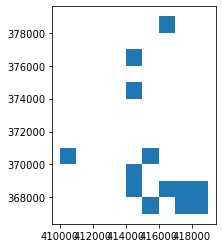

In [36]:
# take look
site.plot(figsize=(4,4))
# save as a new file 
out_file_path = r"../content/landscape_character_grid/site_area.shp"
site.to_file(out_file_path)

In [40]:
# get bounds of each object 
from mask_var import bb
bounds = bb(site)

In [42]:
from mask_var import bb

collection = "str-fts-structureline-1"
walls = {}
gdf = gpd.GeoDataFrame()

# API call 
for index, row in bounds.iterrows():
    str_ngd = NGD(key_os, collection)
    ngd_ = "ngd_" + str(index)
    west, south, east, north = (row['minx']), (row['miny']), (row['maxx']), (row['maxy'])
    bbox_extent = Extent.from_bbox((west, south, east, north), crs="EPSG:27700")
    walls[ngd_] = str_ngd.query(extent=bbox_extent, crs="EPSG:27700", max_results=1000000000)
    if walls[ngd_]['numberReturned'] > 0:
        walls.update(walls[ngd_])
        d =  gpd.GeoDataFrame.from_features((walls[ngd_]), crs="EPSG:27700")
        gdf = gdf.append(d)
        print(ngd_ + " query contains the following number of features:" + str(walls[ngd_]['numberReturned']))
    else:
        print(str(index) + " query is empty")

C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1050 query contains the following number of features:450


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1268 query contains the following number of features:594


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1269 query contains the following number of features:326


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1274 query contains the following number of features:507


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1276 query contains the following number of features:929


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1322 query contains the following number of features:278


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1325 query contains the following number of features:423


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1378 query contains the following number of features:292


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1388 query contains the following number of features:761


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1432 query contains the following number of features:306


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1433 query contains the following number of features:983


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_1487 query contains the following number of features:217
ngd_1488 query contains the following number of features:275


C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\4021020761.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


In [43]:
from mask_var import wall_mask
walls = wall_mask(gdf)

(Text(0.5, 87.0, 'Eastings'), Text(146.8984970623373, 0.5, 'Northings'))

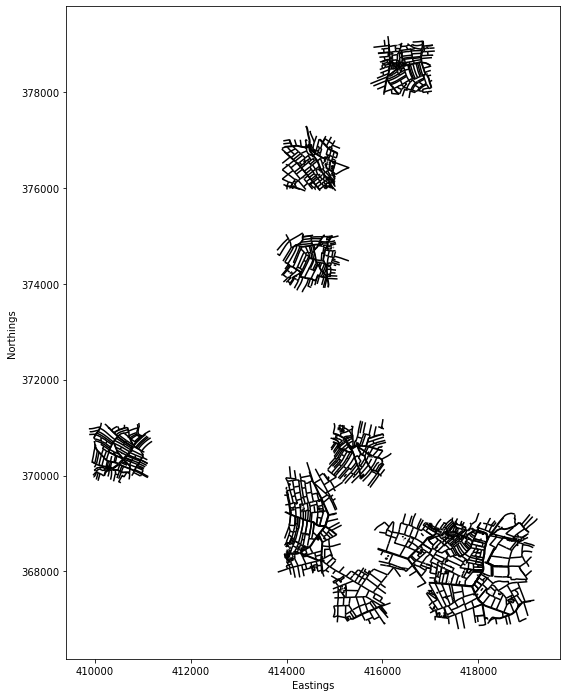

In [44]:
ax = walls.plot(color="black", figsize=(12, 12))
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")

In [45]:
# save as a new file 
out_file_path = r"../content/ngd_boundaries/structureline_walls.shp"
walls.to_file(out_file_path)

C:\Users\alexad\AppData\Local\Temp\ipykernel_24516\1797630284.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  walls.to_file(out_file_path)
